# Spatialize: Simplifying Geostatistics, Bridging Data Gaps

## Geostatistics: The Sparse Data Challenge

Geostatistics is a field dedicated to the analysis, estimation, and modeling of **spatial variables**, such as soil properties, climate data, or mineral concentrations. Unlike traditional statistics, geostatistics emphasizes the *spatial dependencies between observations* rather than treating them as independent.

A key challenge in geostatistics is addressing **sparsity** in spatial datasets - which typically describe limited locations. These data gaps obstruct a full understanding of the variable's domain. The central issue, therefore, is ***estimating values at unmeasured locations***, for which various *interpolation algorithms* have been developed.

**Deterministic models**, such as K Nearest Neighbors (KNN), moving averages, Inverse Distance Weighting (IDW), splines, and polynomials, employ direct calculations for straightforward assessments. However, they can introduce bias through underlying assumptions.
On the other hand, **geostatistical models** integrate probabilistic tools with spatial analysis, offering  more robust assessments and a measure of estimation precision. The main exponent, Kriging, provides an unbiased estimation with minimum variance.

## Introducing Spatialize

Classic geostatistics involve constructing variograms and solving complex equations, which can be time-consuming and require high expertise for optimal assessments. In response, we created ***Spatialize, a Python library designed to simplify geostatistical spatial interpolation***.

Spatialize implements **Ensemble Spatial Analysis (ESA)**, which encompasses two complementary approaches: **Ensemble Spatial Interpolation (ESI)** and **Ensemble Spatial Simulation (ESS)**. These novel methods address the limitations of traditional geostatistical approaches by leveraging ensemble learning techniques.

This introduction focuses on the ESI model. This data-driven method employs ensemble learning to improve interpolation accuracy and efficiency by combining multiple local estimates as follows:

1. **Space partitioning**: A stochastic space partitioning algorithm repeatedly divides the study area into different spatial configurations, creating a set of distinct space partitions.
2. **Local interpolation**: For each target location, a local interpolator generates estimates within each partition cell containing that location.
3. **Aggregation**: The estimates are combined to produce the final assessment.

The variance of a loss function across all partitions provides a quantitative measure of estimation uncertainty and precision.

The following isualization of the ESI algorithm for a single target location using three random partitions

![Visualization of the ESI algorithm for a single target location using three random partitions](ESI_procedure.png)

For an in-depth exploration of the ESI algorithm and the Spatialize library, please refer to [this article](https://link.springer.com/article/10.1007/s11053-021-09860-2), [this article](https://arxiv.org/abs/2507.17867), and especially [this article](https://www.nature.com/articles/s41598-025-08844-z).

The latter offers an interpretation of the ESI model as a bayesian generative model. Namely, if we consider a space $S$, and random variables $S^*$ and $Z$, where $S^*$ represents a partition of $S$ and $Z$ a variable measured at a given location $x \in S$, the generation of Z can be characterised by the Bayesian model:
$$p(S^*,Z)=p(Z, S^*)=p(Z|S^*)\cdot p(S^*)$$

Considering a set of multiple, distinct partitions of $S$, we can characterize the marginal distribution of $Z$:
$$p(Z)=\mathbb{E}_{S^*}[p(Z|S^*)]$$

Then, considering $Z$ is actually measured at a position $x \in S$, and that $x$ can only belong to the (say) k-th element or *cell* of the partition $S^*$ ($S^*_k$), we have:
$$p(Z(x))=\mathbb{E}_{S^*}[p(Z(x)|x\in S^*_k)]$$

## Overview
Spatialize offers:
- An optimization tool to select ESI parameters (``esi_hparams_search``).
- Two implementation methods for the ESI algorithm (``esi_griddata`` and ``esi_nongriddata``).

Three different local interpolation functions are currently available — Inverse Distance Weighting, Adaptive Inverse Distance Weighting and a Kriging variant — as well as two different space partitioning techniques: Mondrian and Voronoi partitions.

## Inputs
For data in D-dimensions, we have:

- ``points: numpy.ndarray``

    Locations of the sampled data ($\text{N}_{\text{samples}}$×D-dimensional array).

- ``values: numpy.ndarray``

    Sampled data values ($\text{N}_{\text{samples}}$ x1-dimensional array).

- ``xi: numpy.ndarray``

    Interpolation locations  -  i.e. the points where the variable will be calculated. In the case of grid data, it is a D-dimensional array or tuple of grids; in the case of non-grid data, it is an $\text{N}_{\text{locations}}$×D-dimensional array of coordinates.


## Installation

The latest version of Spatialize can be directly installed through PyPI:

``pip install spatialize``

## Core Features 

### Datasets
Spatialize offer different integrated datasets. 
For example, the function ``load_drill_holes_andes_2D()`` loads a set of 2-D measurements for copper (Cu), which includes an array of locations to perform the interpolation, reference kriging estimates and variogram configurations.


In [1]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Importar ESI desde repositorio, no desde instalación python, borrar antes de publicar!!
import sys
sys.path.append('../')
import import_helper
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

from spatialize.data import load_drill_holes_andes_2D

# Here, we'll just use the inputs and target locations
samples, target_locations, _, _ = load_drill_holes_andes_2D()

# Input variables for estimation
points = samples[['x', 'y']].values
values = samples[['cu']].values[:, 0]

# 3D locations for non-gridded estimations
xi = target_locations[['x', 'y']].values


### Parameter Search

The function ``esi_hparams_search`` finds optimal ESI parameters from a range of user-specified alternatives, using the k-fold method.

#### Example

In [2]:
from spatialize.gs.esi import esi_hparams_search
import numpy as np

search_result = esi_hparams_search(points,
                                   values,
                                   xi,
                                   k=-1,
                                   local_interpolator='idw',
                                   p_process="mondrian",
                                   griddata=False,
                                   alpha=[0.6, 0.7, 0.8, 0.9],
                                   exponent=np.arange(0.2, 9, 0.5)
                                   )

finished 100% of 72 iterations ... 

done (elapsed time: 36s)


The ``best_result()`` method returns a dictionary containing the optimal parameter set:

In [3]:
search_result.best_result()

{'cv_error': 14.78516891340677,
 'local_interpolator': 'idw',
 'n_partitions': 100,
 'exponent': 4.699999999999999,
 'alpha': 0.6,
 'result_data_index': 9,
 'agg_function': <function spatialize.gs.esi.aggfunction.mean(samples)>,
 'p_process': 'mondrian'}

The ``plot_cv_error()`` method plots a summary of the errors among the different configurations tested in the grid search:

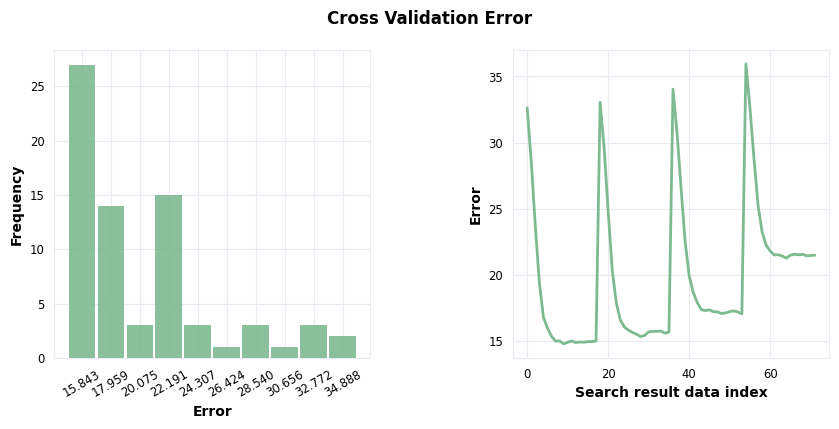

In [4]:
import matplotlib.pyplot as plt
search_result.plot_cv_error(theme='whitegrid')
plt.show()

### ESI Implementation
The functions ``esi_griddata`` and ``esi_nongriddata`` implement the ESI algorithm, for grid-based locations and free-format locations respectively.

#### Example
Here we'll show the basic usage of the non-gridded implementation. The optimal parameters found in the grid search can be incorporated through the argument ``best_params_found``.

In [5]:
from spatialize.gs.esi import esi_nongriddata

result = esi_nongriddata(points,
                         values,
                         xi,
                         n_partitions = 100,
                         best_params_found = search_result.best_result())

finished 100% of 100 iterations ... 

done (elapsed time: 11s)


The ``_estimation`` method returns the estimates for all points in xi:

In [6]:
result._estimation

array([0.49007627, 0.48828375, 0.49275222, ..., 0.42674917, 0.42502066,
       0.42795736], shape=(60000,), dtype=float32)

The ``precision()`` method quantifies uncertainty for each estimate:

In [7]:
result.precision()

array([0.00197876, 0.00190746, 0.00096082, ..., 0.00021001, 0.00024118,
       0.0012454 ], shape=(60000,))

The ``quick_plot()`` method can be employed to rapidly plot 2D estimates and their precision.

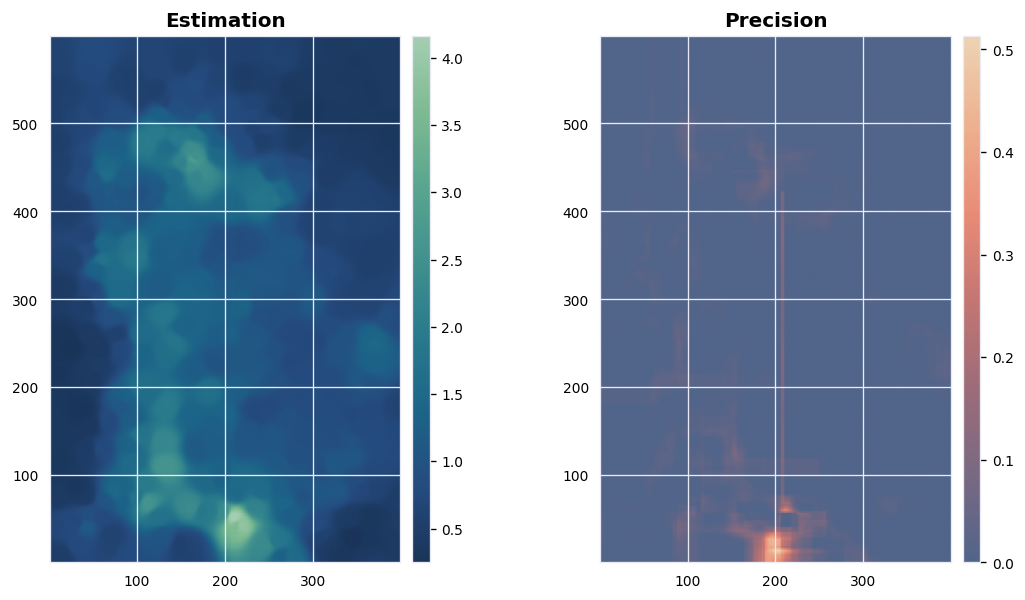

In [8]:
result.quick_plot(theme = 'whitegrid')
plt.show()

And the ``preview_esi_samples()`` method displays the estimates from a random subset of partitions,

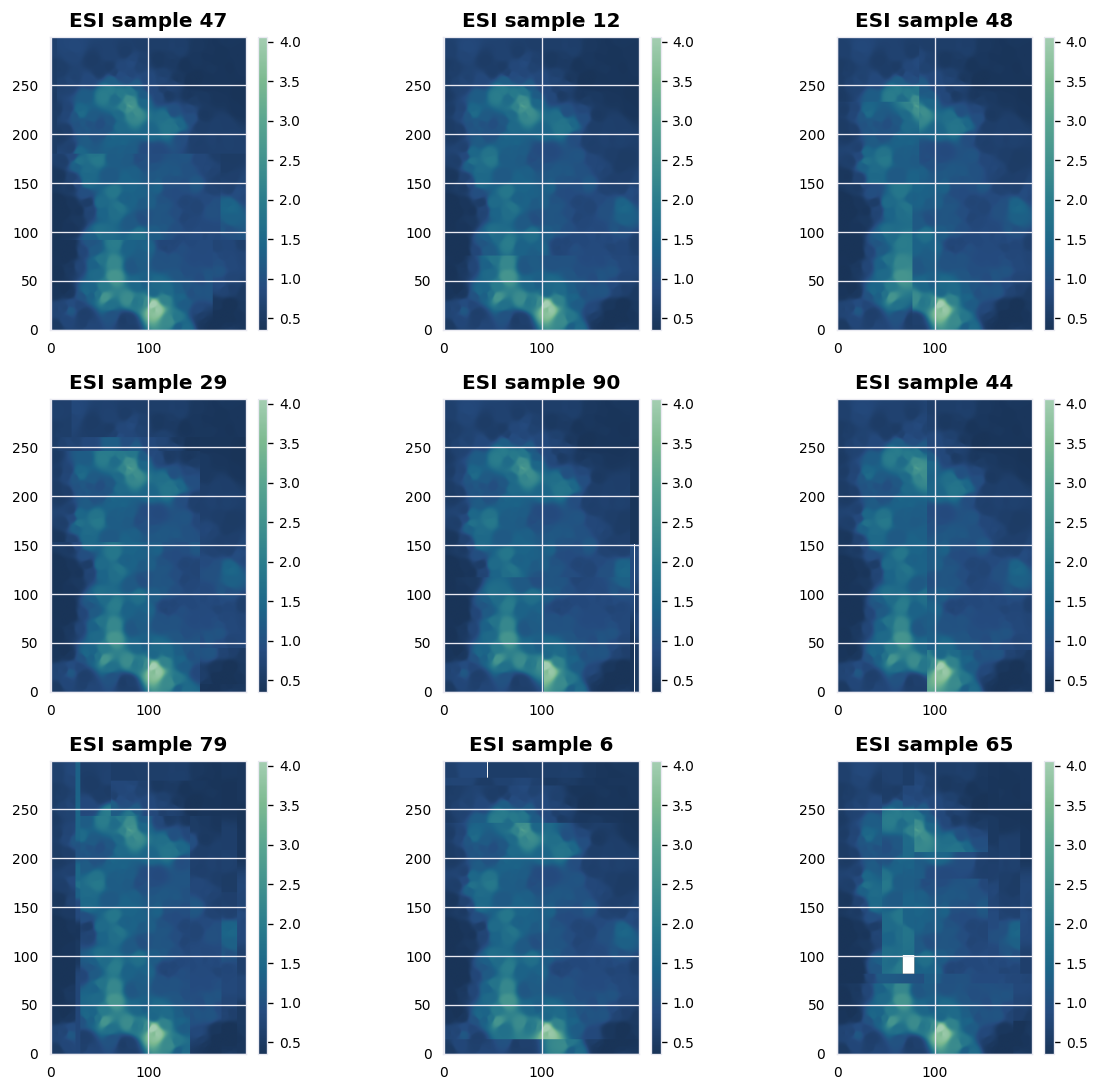

In [9]:
result.preview_esi_samples(theme='whitegrid')
plt.show()